<a href="https://colab.research.google.com/github/Mino94/amazon-recommender-system/blob/main/MF_amazon_recommander_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender System Using Amazon Reviews

In [ ]:
import json
import gzip
from urllib.request import urlopen

import random
from collections import defaultdict

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz

--2021-06-08 12:58:39--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/octet-stream]
Saving to: ‘AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88.87M  74.7MB/s    in 1.2s    

2021-06-08 12:58:40 (74.7 MB/s) - ‘AMAZON_FASHION.json.gz’ saved [93185167/93185167]



In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_AMAZON_FASHION.json.gz

--2021-06-08 12:58:40--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_AMAZON_FASHION.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31372500 (30M) [application/octet-stream]
Saving to: ‘meta_AMAZON_FASHION.json.gz’

meta_AMAZON_FASHION 100%[===================>]  29.92M  58.6MB/s    in 0.5s    

2021-06-08 12:58:41 (58.6 MB/s) - ‘meta_AMAZON_FASHION.json.gz’ saved [31372500/31372500]



# 데이터 로드

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Fashion Item Data

In [ ]:
### load the meta data

data = []
with gzip.open('meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

186637
{'title': 'Slime Time Fall Fest [With CDROM and Collector Cards and Neutron Balls, Incredi-Ball and Glow Stick Necklace, Paper Fram', 'image': ['https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL._US40_.jpg'], 'brand': 'Group Publishing (CO)', 'feature': ['Product Dimensions:\n                    \n8.7 x 3.6 x 11.4 inches', 'Shipping Weight:\n                    \n2.4 pounds'], 'rank': '13,052,976inClothing,Shoesamp;Jewelry(', 'date': '8.70 inches', 'asin': '0764443682'}


In [ ]:
df = pd.DataFrame.from_dict(data)

df.head()

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,[https://images-na.ssl-images-amazon.com/image...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,[https://images-na.ssl-images-amazon.com/image...,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",[https://images-na.ssl-images-amazon.com/image...,Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,[https://images-na.ssl-images-amazon.com/image...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(df5))

430
186207


## User Review data 전처리

In [ ]:
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

print(len(data))
print(data[0])

883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [ ]:
df = pd.DataFrame.from_dict(data)

print(len(df))

883636


In [ ]:
df_fashion_review = df[(df.verified == True)]
df_fashion_review = df_fashion_review.sort_values(by=['unixReviewTime'], ignore_index=True)
df_fashion_review = df_fashion_review[(df_fashion_review.unixReviewTime >= 1483196400)] # 2017년 이후 리뷰

print(len(df_fashion_review))
df_fashion_review.head()

225339


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
603360,1.0,True,"01 1, 2017",A2D9XU6VBGO4HU,B01DBMTFA4,Amazon Customer,Sad,One Star,1483228800,NaN,{'Color:': ' Grey'},NaN
603361,5.0,True,"01 1, 2017",A1TQIXB48V40T7,B019NQ5Q14,Kait,"Thick and cozy, just as pictured. The tag is m...","Thick and cozy, just as pictured. The tag ...",1483228800,NaN,NaN,NaN
603362,1.0,True,"01 1, 2017",AF7241JYDTI8A,B01HD1C7PY,Rhonda,I ordered a 2xx and it was soooooo small it fi...,What a rip off!,1483228800,NaN,NaN,NaN
603363,5.0,True,"01 1, 2017",AKHU2R9PJP22D,B017UVT3F4,J Cole,Granddaughter loves it.,Five Stars,1483228800,NaN,"{'Size:': ' 5', 'Color:': ' Grey Multi'}",NaN
603364,5.0,True,"01 1, 2017",A3BJHX7M023ZBI,B018W8N7EW,Moroccomom,Nice tee for shorts and capris.,Great tee shirt,1483228800,NaN,NaN,NaN


In [ ]:
review_columns = ['overall', 'reviewerID', 'asin', 'reviewText', 'summary','unixReviewTime']

df_fashion_review = df_fashion_review[review_columns]
df_fashion_review.head()

,overall,reviewerID,asin,reviewText,summary,unixReviewTime
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad,One Star,1483228800
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m...","Thick and cozy, just as pictured. The tag ...",1483228800
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...,What a rip off!,1483228800
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.,Five Stars,1483228800
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.,Great tee shirt,1483228800


In [ ]:
# 컬럼명 변경
df_fashion_review.rename(columns={
    "overall": "rating",
    "reviewerID": "user_id",
    "asin": "item_id",
    "reviewText": "review",
    "unixReviewTime": "timestamp"
}, inplace=True)

df_fashion_review.head()

,rating,user_id,item_id,review,summary,timestamp
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad,One Star,1483228800
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m...","Thick and cozy, just as pictured. The tag ...",1483228800
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...,What a rip off!,1483228800
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.,Five Stars,1483228800
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.,Great tee shirt,1483228800


In [ ]:
df_fashion_review.shape

(225339, 6)

In [ ]:
df_fashion_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225339 entries, 603360 to 828698
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   rating     225339 non-null  float64
 1   user_id    225339 non-null  object 
 2   item_id    225339 non-null  object 
 3   review     224899 non-null  object 
 4   summary    225153 non-null  object 
 5   timestamp  225339 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 12.0+ MB


In [ ]:
df_fashion_review.describe()['rating'].T

count    225339.000000
mean          3.981659
std           1.398888
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df_fashion_review.rating.min()))
print('Maximum rating is: %d' %(df_fashion_review.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

## 결측치 처리

In [ ]:
print('Number of missing values across columns: \n',df_fashion_review.isnull().sum())

Number of missing values across columns: 
 rating         0
user_id        0
item_id        0
review       440
summary      186
timestamp      0
dtype: int64


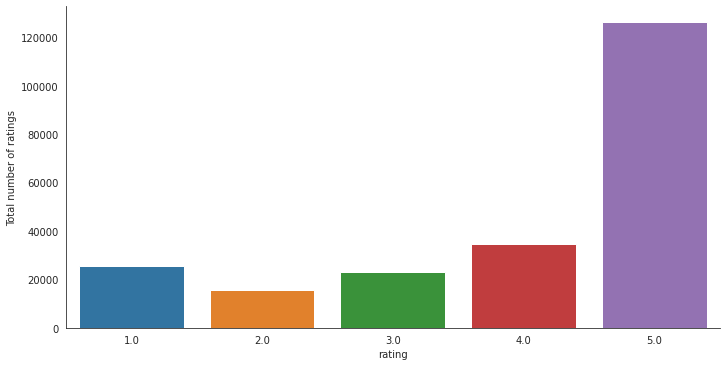

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df_fashion_review, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

### User와 Item 유일한 값

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df_fashion_review.shape[0])
print("Total No of Users   :", len(np.unique(df_fashion_review.user_id)))
print("Total No of products  :", len(np.unique(df_fashion_review.item_id)))

Total data 
--------------------------------------------------

Total no of ratings : 225339
Total No of Users   : 202923
Total No of products  : 60820


### 불필요한 컬럼 제거

- timestamp
- summary

In [ ]:
df_fashion_review.drop(['timestamp', 'summary'], axis=1, inplace=True)

In [ ]:
df_fashion_review.head()

,rating,user_id,item_id,review
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m..."
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.


## rating 컬럼 분석

In [ ]:
no_of_rated_products_per_user = df_fashion_review.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

user_id
A3OP70LPLALBKN    17
A37K0VP2H8FKOU    16
A3VGHF7VNFBMCQ    13
A2AEJ9NTLWD61V    12
A1C1UK1VCQ6ZLU    11
Name: rating, dtype: int64

유저들이 여러개의 제품을 평가 했다고 볼 수있다.

In [ ]:
no_of_rated_products_per_user.describe()

count    202923.000000
mean          1.110466
std           0.465260
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          17.000000
Name: rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

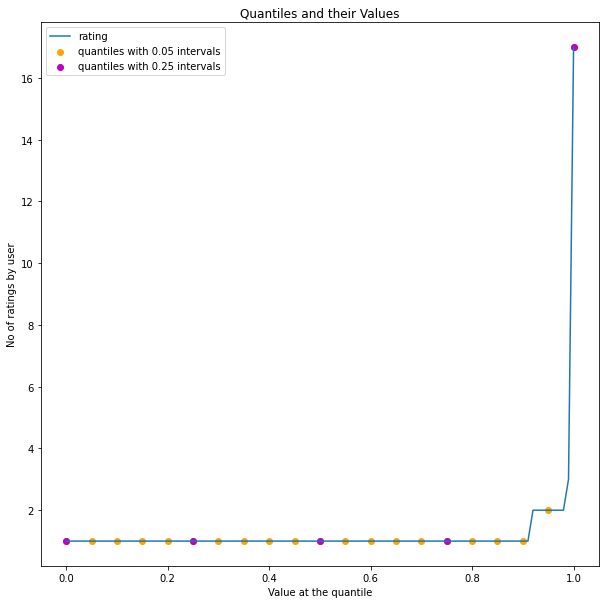

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n 사용자 당 10 개 이상의 제품 수 : {}\n'.format(sum(no_of_rated_products_per_user >= 10)) )


 사용자 당 10 개 이상의 제품 수 : 7



## Popularity Based Recommendation

3번이상 평가한 유저들로 기반

In [ ]:
new_df=df_fashion_review.groupby("item_id").filter(lambda x:x['rating'].count() >=3)

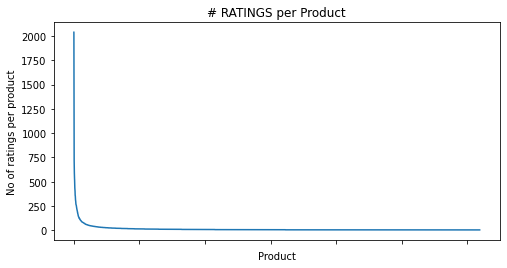

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='item_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show();

In [ ]:
len(new_df)

167507

In [ ]:
#제품의 평균등급
new_df.groupby('item_id')['rating'].mean().head()

item_id
B00004T3SN    5.000000
B00007GDFV    3.636364
B00008JOQI    3.692308
B00008JPRZ    4.307692
B00008JQF0    4.400000
Name: rating, dtype: float64

In [ ]:
new_df.groupby('item_id')['rating'].mean().sort_values(ascending=False).head()

item_id
B00004T3SN    5.0
B016MUI3DW    5.0
B016ZEKLZ8    5.0
B016YVVBF6    5.0
B016XG4FBE    5.0
Name: rating, dtype: float64

In [ ]:
#제품평점총수
new_df.groupby('item_id')['rating'].count().sort_values(ascending=False).head()

item_id
B000V0IBDM    2039
B000KPIHQ4    2031
B00XT15P8E    1787
B000YFSR5G    1652
B00I0VHS10    1642
Name: rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('item_id')['rating'].mean())

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df_fashion_review.groupby('item_id')['rating'].count())

ratings_mean_count.head()

,rating,rating_counts
item_id,,
B00004T3SN,5.000000,3
B00007GDFV,3.636364,33
B00008JOQI,3.692308,13
B00008JPRZ,4.307692,13
B00008JQF0,4.400000,15


In [ ]:
ratings_mean_count['rating_counts'].max()

2039

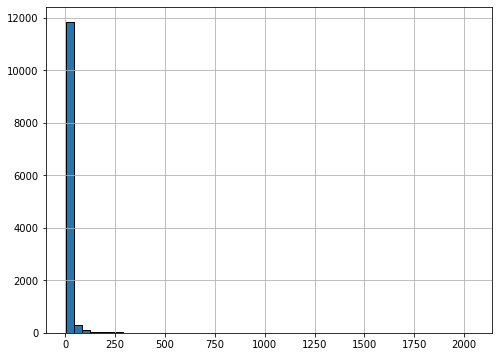

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50);

**outlier 제거**

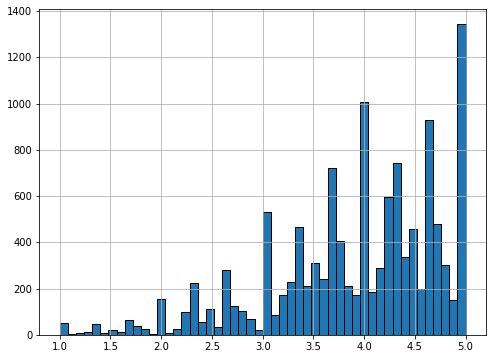

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50);

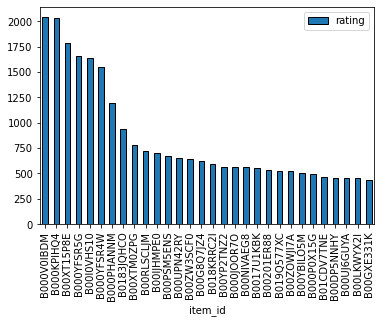

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('item_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Base Line Model

- Matrix Factorization(협업 필터링)



In [ ]:
df_ratings = pd.read_csv('./fashion_user_item_review.csv')
df_ratings.head()

,rate,user_id,item_id,review,summary,timestamp,title,brand,price
0,1,A2D9XU6VBGO4HU,B01DBMTFA4,Sad,One Star,2017-01-01,HIBROS Love Knot Cufflinks Stainless Steel Tux...,NaN,NaN
1,1,A3CRODW9YZRIOT,B01DBMTFA4,BAD,One Star,2017-01-06,HIBROS Love Knot Cufflinks Stainless Steel Tux...,NaN,NaN
2,4,A3D3597E9WA3CU,B01DBMTFA4,ok,ok,2017-01-17,HIBROS Love Knot Cufflinks Stainless Steel Tux...,NaN,NaN
3,5,A3IWS9RVTPLHNH,B01DBMTFA4,really good. Were as expected.,Five Stars,2017-01-18,HIBROS Love Knot Cufflinks Stainless Steel Tux...,NaN,NaN
4,5,A2T52GTR58N1Y7,B01DBMTFA4,very nice looking,Five Stars,2017-01-19,HIBROS Love Knot Cufflinks Stainless Steel Tux...,NaN,NaN


**사용자-아이팀 pivot table을 만드는 작업**

In [ ]:
df_fashion_review

,rating,user_id,item_id,review
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m..."
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.
...,...,...,...,...
828694,1.0,A32M1OZKT7IC43,B01GGEQSWM,I hate the cut it's almost boarding school sty...
828695,3.0,A1FKS778XITHK6,B01GGEQSWM,Product is as pictured by I usually take a lar...
828696,5.0,AQTT6V6MSMYC8,B01GGGSD6E,This is a great product to help show respect f...
828697,5.0,A2P6021FB6L6T6,B01HHJZNBM,"Vere, very good"


In [ ]:
df_smallsize_ratings = df_ratings.head(50000)
df_user_fashion_ratings = df_smallsize_ratings.pivot(
    index='user_id',
    columns = 'item_id',
    values='rate'
).fillna(0)

In [ ]:
df_user_fashion_ratings.head()

item_id,B00008JVTT,B00066G516,B000ER9V68,B000GHMRLW,B000GHRZN2,B000HQ4P9O,B000JOOR7O,B000KPIHQ4,B000NGJ41W,B000PHANNM,B000PMNS3E,B000PMPTF4,B000PMPTGI,B000POJKMU,B000POL05U,B000PQJQUY,B000V0IBDM,B000V588EO,B000VIUJLG,B000YFSR5G,B0014F57YY,B0014F8TIU,B0017U1KBK,B0018N8CHQ,B001AXC4YG,B001F8LJ92,B001G7R0CC,B001GIO77C,B001IKJOLW,B001LFP0EO,B001T4MSU6,B0027L8RSW,B002B90VTI,B002QATOV8,B002RC6FWQ,B002Z3N1HE,B003950BDY,B003BRC73C,B003ESTRW2,B003GJZDGS,...,B01GZZIWKI,B01GZZOZ8G,B01H059U4Y,B01H0C5A9Q,B01H1LQMXO,B01H1P2YTG,B01H1WHBPG,B01H3D4MZK,B01H3DCZBI,B01H3H4EB8,B01H4DGICE,B01H4P97HA,B01H5A1WUO,B01H62UHX4,B01H6FTQRY,B01H6Z43A4,B01H79VTDS,B01H7KY678,B01H7N6240,B01H7RIHEO,B01HBI0KW6,B01HBJW7DU,B01HBLV3K6,B01HC7ZP1M,B01HCHY6AI,B01HCJMCU2,B01HCVAP5O,B01HCWVWF0,B01HD1C7PY,B01HE9KXKQ,B01HEGKFKM,B01HEISONU,B01HFKK1AG,B01HFKZ57K,B01HFZM5RS,B01HH5SFNO,B01HHUQEY6,B01HIA2Y80,B01HIVIU82,B01HJGJ9LS
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A0010606488RW7ZH6EP7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0254933A6GXCEJ2WU0K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02624829WK3PDCDC0XY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0315527BAKOZY6T8TX2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A06191098432NALLJUET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


이제 아래와 같이 데이터를 조금 변경해서 진행하겠습니다.

1. pivot table을 matrix로 변환
2. np.mean(axis = 1)을 통해 각 사용자들이 매기는 평점 평균을 구함
3. 1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [ ]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것 
matrix = df_user_fashion_ratings.values

# user_ratings_mean은 사용자의 평균 평점
user_ratings_mean = np.mean(matrix, axis=1)

# R_user_mean : 사용자-아이템에 대해 사용자 평균 평점을 뺀 것
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [ ]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
matrix.shape

(45330, 1662)

In [ ]:
user_ratings_mean.shape

(45330,)

In [ ]:
matrix_user_mean.shape

(45330, 1662)

In [ ]:
pd.DataFrame(matrix_user_mean, columns=df_user_fashion_ratings.columns).head()

item_id,B00008JVTT,B00066G516,B000ER9V68,B000GHMRLW,B000GHRZN2,B000HQ4P9O,B000JOOR7O,B000KPIHQ4,B000NGJ41W,B000PHANNM,B000PMNS3E,B000PMPTF4,B000PMPTGI,B000POJKMU,B000POL05U,B000PQJQUY,B000V0IBDM,B000V588EO,B000VIUJLG,B000YFSR5G,B0014F57YY,B0014F8TIU,B0017U1KBK,B0018N8CHQ,B001AXC4YG,B001F8LJ92,B001G7R0CC,B001GIO77C,B001IKJOLW,B001LFP0EO,B001T4MSU6,B0027L8RSW,B002B90VTI,B002QATOV8,B002RC6FWQ,B002Z3N1HE,B003950BDY,B003BRC73C,B003ESTRW2,B003GJZDGS,...,B01GZZIWKI,B01GZZOZ8G,B01H059U4Y,B01H0C5A9Q,B01H1LQMXO,B01H1P2YTG,B01H1WHBPG,B01H3D4MZK,B01H3DCZBI,B01H3H4EB8,B01H4DGICE,B01H4P97HA,B01H5A1WUO,B01H62UHX4,B01H6FTQRY,B01H6Z43A4,B01H79VTDS,B01H7KY678,B01H7N6240,B01H7RIHEO,B01HBI0KW6,B01HBJW7DU,B01HBLV3K6,B01HC7ZP1M,B01HCHY6AI,B01HCJMCU2,B01HCVAP5O,B01HCWVWF0,B01HD1C7PY,B01HE9KXKQ,B01HEGKFKM,B01HEISONU,B01HFKK1AG,B01HFKZ57K,B01HFZM5RS,B01HH5SFNO,B01HHUQEY6,B01HIA2Y80,B01HIVIU82,B01HJGJ9LS
0,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,...,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602,-0.000602
1,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,...,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008
2,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,...,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008
3,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,...,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.003008,-0.0



1.   사용자 45330명이 1662개의 제품에 대해 평점
2.   사용자 45330명의 각각 평균 평점
3.   사용자 45330명의 1662개의 제품에 대해 평점을 조금 변경 (1번 값 - 2번값)



### SVD(Singular Value decomposion), 특이값 분해

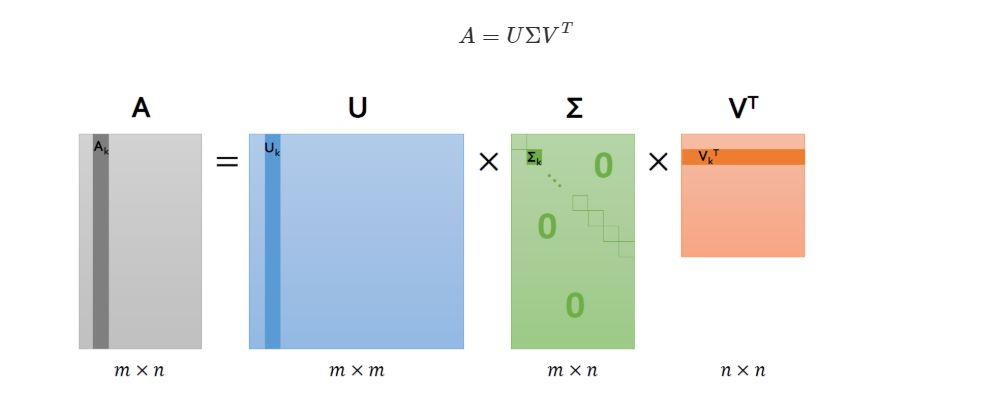

이제 SVD를 이용해 Matrix Factorization을 진행해봅니다.

앞서서는 scikit learn을 이용해 TruncatedSVD를 이용했는데요. 이번에는 scipy를 이용해 Truncated SVD를 구해봅니다.

이 둘의 차이점은 scikit learn에서 제공해주는 TruncatedSVD는 U, Sigma, Vt 반환 값을 제공하지 않습니다.
하지만, Scipy를 이용하면 이 반환값들을 제공받을 수 있죠.

Scipy에서 제공해주는 Truncate SVD는 scipy.sparse.linalg.svds를 이용하면 됩니다. 저는 이것을 이용했습니다.

이렇게 사용하면 반환값이 U 행렬, Sigma 행렬, V 전치 행렬(Vt)가 나오게 됩니다

In [ ]:
# scipy에서 제공해주는 svd.  
# U 행렬, sigma 행렬, V 전치 행렬을 반환.
U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [ ]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(45330, 12)
(12,)
(12, 1662)


이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태입니다.
즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 합니다.

In [ ]:
sigma = np.diag(sigma)

In [ ]:
sigma.shape

(12, 12)

In [ ]:
sigma[0]

array([107.95696287,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [ ]:
sigma[1]

array([  0.        , 112.33298579,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

이렇게 대칭 행렬로 변환이 되었습니다.

현재 까지 상황을 정리하면 아래와 같습니다.
1. 원본 user-item 평점 행렬
2. 이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
3. 2번의 값을 SVD 적용해 U, Sigma, Vt 행렬을 구함
4. Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음 이를 대칭행렬로 변환

matrix_user_mean을 SVD를 적용해 분해를 한 상태입니다.
이제, 다시 원본 행렬로 복구
- U, Sigma, Vt의 내적을 수행

In [ ]:
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [ ]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_fashion_ratings.columns)
df_svd_preds.head()

item_id,B00008JVTT,B00066G516,B000ER9V68,B000GHMRLW,B000GHRZN2,B000HQ4P9O,B000JOOR7O,B000KPIHQ4,B000NGJ41W,B000PHANNM,B000PMNS3E,B000PMPTF4,B000PMPTGI,B000POJKMU,B000POL05U,B000PQJQUY,B000V0IBDM,B000V588EO,B000VIUJLG,B000YFSR5G,B0014F57YY,B0014F8TIU,B0017U1KBK,B0018N8CHQ,B001AXC4YG,B001F8LJ92,B001G7R0CC,B001GIO77C,B001IKJOLW,B001LFP0EO,B001T4MSU6,B0027L8RSW,B002B90VTI,B002QATOV8,B002RC6FWQ,B002Z3N1HE,B003950BDY,B003BRC73C,B003ESTRW2,B003GJZDGS,...,B01GZZIWKI,B01GZZOZ8G,B01H059U4Y,B01H0C5A9Q,B01H1LQMXO,B01H1P2YTG,B01H1WHBPG,B01H3D4MZK,B01H3DCZBI,B01H3H4EB8,B01H4DGICE,B01H4P97HA,B01H5A1WUO,B01H62UHX4,B01H6FTQRY,B01H6Z43A4,B01H79VTDS,B01H7KY678,B01H7N6240,B01H7RIHEO,B01HBI0KW6,B01HBJW7DU,B01HBLV3K6,B01HC7ZP1M,B01HCHY6AI,B01HCJMCU2,B01HCVAP5O,B01HCWVWF0,B01HD1C7PY,B01HE9KXKQ,B01HEGKFKM,B01HEISONU,B01HFKK1AG,B01HFKZ57K,B01HFZM5RS,B01HH5SFNO,B01HHUQEY6,B01HIA2Y80,B01HIVIU82,B01HJGJ9LS
0,0.000609,0.000609,0.000610,0.000007,0.000007,6.090212e-04,0.000522,1.582164e-07,0.000609,-0.000007,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,-7.850251e-07,0.000609,6.090185e-04,-8.691209e-07,0.000609,0.000607,0.000610,0.000608,0.000609,0.000611,0.000609,0.000609,0.000017,0.000610,0.000610,0.000609,0.000609,0.000609,0.000609,0.000611,0.000609,0.000609,0.000609,0.000608,...,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000612,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000608,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,6.090233e-04
1,0.003049,0.003049,0.003052,-0.000408,-0.000408,3.049179e-03,0.002518,-7.537585e-05,0.003050,-0.000296,0.003051,0.003051,0.003049,0.003050,0.003050,0.003051,-8.021608e-05,0.003052,3.049163e-03,-5.638569e-04,0.003049,0.003037,0.003053,0.003043,0.003049,0.003060,0.003051,0.003050,-0.000090,0.003055,0.003054,0.003049,0.003049,0.003049,0.003049,0.003058,0.003049,0.003049,0.003051,0.003045,...,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003068,0.003050,0.003049,0.003049,0.003049,0.003049,0.003052,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003044,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,0.003049,3.049191e-03
2,0.000002,0.003066,-0.000126,-0.000006,-0.000006,2.042801e-07,-0.001369,6.024872e-06,-0.000021,0.000005,-0.000125,-0.000129,-0.000010,-0.000022,-0.000017,-0.000100,-5.799176e-06,-0.000114,9.484652e-07,3.737479e-07,0.000008,-0.000199,0.004010,-0.000063,-0.000001,-0.000444,-0.000104,-0.000015,-0.000002,-0.000232,-0.000230,0.000010,0.000015,0.000018,-0.000007,-0.000355,0.000007,0.000015,-0.000083,0.000004,...,0.000008,-0.000001,0.000017,0.000020,0.000020,0.000016,0.000016,0.000017,0.001829,0.000018,0.000012,0.000018,0.000014,0.000018,0.000015,-0.000003,0.000016,-0.000669,-0.000044,-0.000002,0.000018,0.000007,0.000020,-0.000121,0.000018,0.000011,0.000017,0.000007,0.000020,0.000020,-0.000001,-0.000079,0.000012,0.000018,0.000016,0.000018,0.000007,0.000019,0.000014,-3.541013e-07
3,0.003046,0.003046,0.003049,-0.000106,-0.000106,3.046389e-03,0.002584,-2.500920e-05,0.003047,-0.000121,0.003048,0.003048,0.003047,0.003047,0.003047,0.003048,-2.976727e-05,0.003049,3.046375e-03,-1.765256e-04,0.003046,0.003035,0.003050,0.003041,0.003046,0.003057,0.003048,0.003047,0.000027,0.003051,0.003051,0.003046,0.003046,0.003046,0.003047,0.003054,0.003046,0.003046,0.003048,0.003043,...,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003047,0.003046,0.003063,0.003047,0.003046,0.003046,0.003046,0.003046,0.003049,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003042,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,0.003046,3.046400e-03
4,0.000609,0.000609,0.000609,0.000008,0.000008,6.090064e-0

In [ ]:
df_svd_preds.shape

(45330, 1662)

아래와 같은 기능의 함수를 만듭니다.

- 인자로 사용자 아이디, 제품 정보 테이블, 평점 테이블 등을 받음
- 사용자 아이디에 SVD로 나온 결과의 제품 평점이 가장 높은 데이터 순으로 정렬
- 사용자가 본 데이터를 제외
- 사용자가 안 본 제품에서 평점이 높은 것을 추천

In [ ]:
def recommend_items(df_svd_preds, user_id, ori_items_df, ori_ratings_df, num_recommendations=5):
    
    #현재는 index로 적용이 되어있으므로 user_id - 1을 해야함.
    user_row_number = user_id - 1
    
    # 최종적으로 만든 pred_df에서 사용자 index에 따라 제품 데이터 정렬 -> 제품 평점이 높은 순으로 정렬 됌
    sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)
    
    # 원본 평점 데이터에서 user id에 해당하는 데이터를 뽑아낸다. 
    user_data = ori_ratings_df[ori_ratings_df.user_id == user_id]
    
    # 위에서 뽑은 user_data와 원본 제품 데이터를 합친다. 
    user_history = user_data.merge(ori_items_df, on = 'item_id').sort_values(['rating'], ascending=False)
    
    # 원본 제품 데이터에서 사용자가 본 제품 데이터를 제외한 데이터를 추출
    recommendations = ori_items_df[~ori_items_df['item_id'].isin(user_history['item_id'])]
    # 사용자의 제품 평점이 높은 순으로 정렬된 데이터와 위 recommendations을 합친다. 
    recommendations = recommendations.merge(pd.DataFrame(sorted_user_predictions).reset_index(), on = 'item_id')
    # 컬럼 이름 바꾸고 정렬해서 return
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      

    return user_history, recommendations

In [ ]:
df_item = df5.copy()
df_item.columns = ['title', 'image', 'brand', 'feature', 'rank', 'date', 'item_id',
       'description', 'price', 'also_view', 'also_buy', 'fit', 'details',
       'similar_item', 'tech1']

df_item.head(1)

,title,image,brand,feature,rank,date,item_id,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,[https://images-na.ssl-images-amazon.com/image...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,,,,,,,,


In [ ]:
already_rated, predictions = recommend_items(df_svd_preds, 201, df_item, df_fashion_review, 10)

In [ ]:
re = df_user_fashion_ratings.reset_index()
re.head()

item_id,user_id,B00008JVTT,B00066G516,B000ER9V68,B000GHMRLW,B000GHRZN2,B000HQ4P9O,B000JOOR7O,B000KPIHQ4,B000NGJ41W,B000PHANNM,B000PMNS3E,B000PMPTF4,B000PMPTGI,B000POJKMU,B000POL05U,B000PQJQUY,B000V0IBDM,B000V588EO,B000VIUJLG,B000YFSR5G,B0014F57YY,B0014F8TIU,B0017U1KBK,B0018N8CHQ,B001AXC4YG,B001F8LJ92,B001G7R0CC,B001GIO77C,B001IKJOLW,B001LFP0EO,B001T4MSU6,B0027L8RSW,B002B90VTI,B002QATOV8,B002RC6FWQ,B002Z3N1HE,B003950BDY,B003BRC73C,B003ESTRW2,...,B01GZZIWKI,B01GZZOZ8G,B01H059U4Y,B01H0C5A9Q,B01H1LQMXO,B01H1P2YTG,B01H1WHBPG,B01H3D4MZK,B01H3DCZBI,B01H3H4EB8,B01H4DGICE,B01H4P97HA,B01H5A1WUO,B01H62UHX4,B01H6FTQRY,B01H6Z43A4,B01H79VTDS,B01H7KY678,B01H7N6240,B01H7RIHEO,B01HBI0KW6,B01HBJW7DU,B01HBLV3K6,B01HC7ZP1M,B01HCHY6AI,B01HCJMCU2,B01HCVAP5O,B01HCWVWF0,B01HD1C7PY,B01HE9KXKQ,B01HEGKFKM,B01HEISONU,B01HFKK1AG,B01HFKZ57K,B01HFZM5RS,B01HH5SFNO,B01HHUQEY6,B01HIA2Y80,B01HIVIU82,B01HJGJ9LS
0,A0010606488RW7ZH6EP7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A0254933A6GXCEJ2WU0K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A02624829WK3PDCDC0XY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A0315527BAKOZY6T8TX2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A06191098432NALLJUET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_fashion_review.head()

,rating,user_id,item_id,review
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m..."
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.


In [ ]:
df_fashion_review["user_id"]

603360    A2D9XU6VBGO4HU
603361    A1TQIXB48V40T7
603362     AF7241JYDTI8A
603363     AKHU2R9PJP22D
603364    A3BJHX7M023ZBI
               ...      
828694    A32M1OZKT7IC43
828695    A1FKS778XITHK6
828696     AQTT6V6MSMYC8
828697    A2P6021FB6L6T6
828698    A2FDKSBXCJJQ26
Name: user_id, Length: 225339, dtype: object

In [ ]:
re[re.index==200]['user_id'].values

array(['A10JMZDDFI314F'], dtype=object)

In [ ]:
df_fashion_review[df_fashion_review["user_id"]== 'A10JMZDDFI314F']

,rating,user_id,item_id,review
647261,4.0,A10JMZDDFI314F,B00ZOWJI7A,Instruction sheet lacking info concerning amou...


In [ ]:
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

print(len(data))
print(data[0])

df = pd.DataFrame.from_dict(data)


883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [ ]:
df[df["reviewerID"]== 'A10JMZDDFI314F']

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
286828,4.0,True,"03 5, 2017",A10JMZDDFI314F,B00ZOWJI7A,MMI,Instruction sheet lacking info concerning amou...,"""SOLAR"" generates some heat - cooler then inc...",1488672000,NaN,NaN,NaN


In [ ]:
predictions

,title,image,brand,feature,rank,date,item_id,description,price,also_view,also_buy,fit,details,similar_item,tech1,Predictions
584,CoolFire Solar Watch Fast Charger (compatible ...,[https://images-na.ssl-images-amazon.com/image...,Timechant,[Charge your sophisticated solar watch much fa...,"13,475inClothing,ShoesJewelry(",Timechant,B00ZOWJI7A,[CoolFire Solar Watch Charger is compatible wi...,$3.99,"[B00DBUVKP0, B07DCBZ8N3, B0091N5BJC, B01EFF8J0...","[B074YJ9T4P, B07FWTMWP5, B07LHB398Q, B00DBUVKP...",,,,,3.919898
7,"Vans Adult Classic Slip-On, (Checkerboard) Bla...",[https://images-na.ssl-images-amazon.com/image...,Vans,[Shipping Information:\n \n...,"42,109inClothing,ShoesJewelry(",5 star,B000JOOR7O,[The shoe that started it all. The iconic Vans...,$48.99 - $150.00,,,"class=""a-normal a-align-center a-spacing-smal...",,,,0.558697
978,SAYFUT Women's Butt Lifter Shaper Seamless Tum...,[https://images-na.ssl-images-amazon.com/image...,SAYFUT,"[Size:S,M/L,XL/XXL,3XL(Details, please see our...","9,299inClothing,ShoesJewelry(",5 star,B0183JQHCO,,$7.99 - $12.98,"[B07FYBLPRP, B06XNQ9Z7K, B01H8KRF5C, B071S4DTY...","[B06XNQ9Z7K, B07FYBLPRP, B01H8KRF5C, B07FC1F4B...","class=""a-normal a-align-center a-spacing-smal...",,,,0.002904
475,OAKI Kids Rubber Rain Boots with Easy-On Handl...,[https://images-na.ssl-images-amazon.com/image...,OAKI,[BREATHABLE PROTECTION: Oakiwear Kids Rubber R...,"7,402inClothing,ShoesJewelry(",5 star,B00UPN42RY,[Oakiwear Kids Rubber Rain Boots with Easy-On ...,$16.00 - $22.77,,,"class=""a-normal a-align-center a-spacing-smal...",,,,0.001628
20,Hanes Mens EcoSmart Fleece Sweatpant,[https://images-na.ssl-images-amazon.com/image...,,"[50% Cotton, 50% Polyester, Imported, Drawstri...","13,395inClothing,Shoesamp;Jewelry(",5 star,B000YFSR5G,[The Hanes men's comfort blend EcoSmart sweatp...,$7.73 - $31.69,"[B07KCRJFR9, B01L8JJ174, B00JULWE5O, B06XCQSPF...","[B01L8JJ174, B07KCRJFR9, B01L8JJ1GK, B00T7TU14...","class=""a-normal a-align-center a-spacing-smal...",,,,0.001568
1385,Lux Accessories Womens Extra Large Zip Up Beac...,[https://images-na.ssl-images-amazon.com/image...,,"[Premium Canvas Exterior - Lined Interior, Upp...","1,132,587inClothing,ShoesJewelry(",5 star,B01E989MZM,,$9.95,"[B01NBI49YD, B071WDYR32, B07BH222HK]",[B0716HYJVV],,,,,0.001035
1026,Vans Kids' Classic Slip-On-K,[https://images-na.ssl-images-amazon.com/image...,Vans,"[100% Textile, Imported, Rubber sole, Easy On^...","30,181inClothing,ShoesJewelry(",5 star,B018WJY1RI,"[Introduced in 1979, the slip on is the ""go to...",$26.64 - $79.99,"[B01GJR7ADW, B01MDPT4DO, B01NC0DM1K, B01N0YZF0...","[B01GJR7ADW, B01MDPT4DO, B01LXSD1TW, B01BWML0F...","class=""a-normal a-align-center a-spacing-smal...",,,,0.000950
306,Senchanting Women Winter Warm Ski Knitted Croc...,[https://images-na.ssl-images-amazon.com/image...,Senchanting,[100% Guarantee with high quality;Material:kni...,"65,738inClothing,ShoesJewelry(",5 star,B00MLYE8PQ,[Features: Popular and classic knitted baggy ...,$7.99,"[B01N2KJHS9, B07GXGHNR5, B01M60QHJL, B00NZVHHT...","[B00NZVHHTI, B01N2KJHS9, B01M60QHJL, B00OZ8PW8...","class=""a-normal a-align-center a-spacing-smal...",,,,0.000903
85,swimsuitsforall Women's Loose Short 10 Black,[https://images-na.ssl-images-amazon.com/image...,Beach Belle,[Product Dimensions:\n \n8....,"1,418,268inClothing,ShoesJewelry(",5 star,B009046YFW,,,,"[B07415T676, B01N57FCGG, B01F8P75DQ]",,,,,0.000867
549,WearMe Pro - Classic Half Frame Polarized Semi...,[https://images-na.ssl-images-amazon.com/image...,WearMe Pro,"[Plastic frame, Plastic lens, polarized, Lens ...","15,542inClothing,ShoesJewelry(",5 star,B00XTM0ZPG,,$9.99,"[B01M4O32OW, B07BMQYJKY, B0776GXNFD, B010A83KG...","[B06WLLJSN7, B01M4O32OW, B0108UJZ0M, B07BMQYJK...",,,,,0.000807
